# PetFinderAdoption

The goal of this kernel is to classify animals with different information on a scale from 0 to 4 given various information.

My personal goal is to do an EDA on the dataset, that helps building a better classifier (than the one we used for the course).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pip install missingno
import missingno as msno

Note: you may need to restart the kernel to use updated packages.


In [2]:
%ls data

breed_labels.csv*       state_labels.csv*  test_metadata/   train_images.zip*
color_labels.csv*       test.csv*          test_sentiment/  train_metadata/
embedding/              test_images/       train.csv*       train_sentiment/
sample_submission.csv*  test_images.zip*   train_images/


In [3]:
train = pd.read_csv("data/train.csv")
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [4]:
color = pd.read_csv("data/color_labels.csv")
breed = pd.read_csv("data/breed_labels.csv")
state = pd.read_csv("data/state_labels.csv")

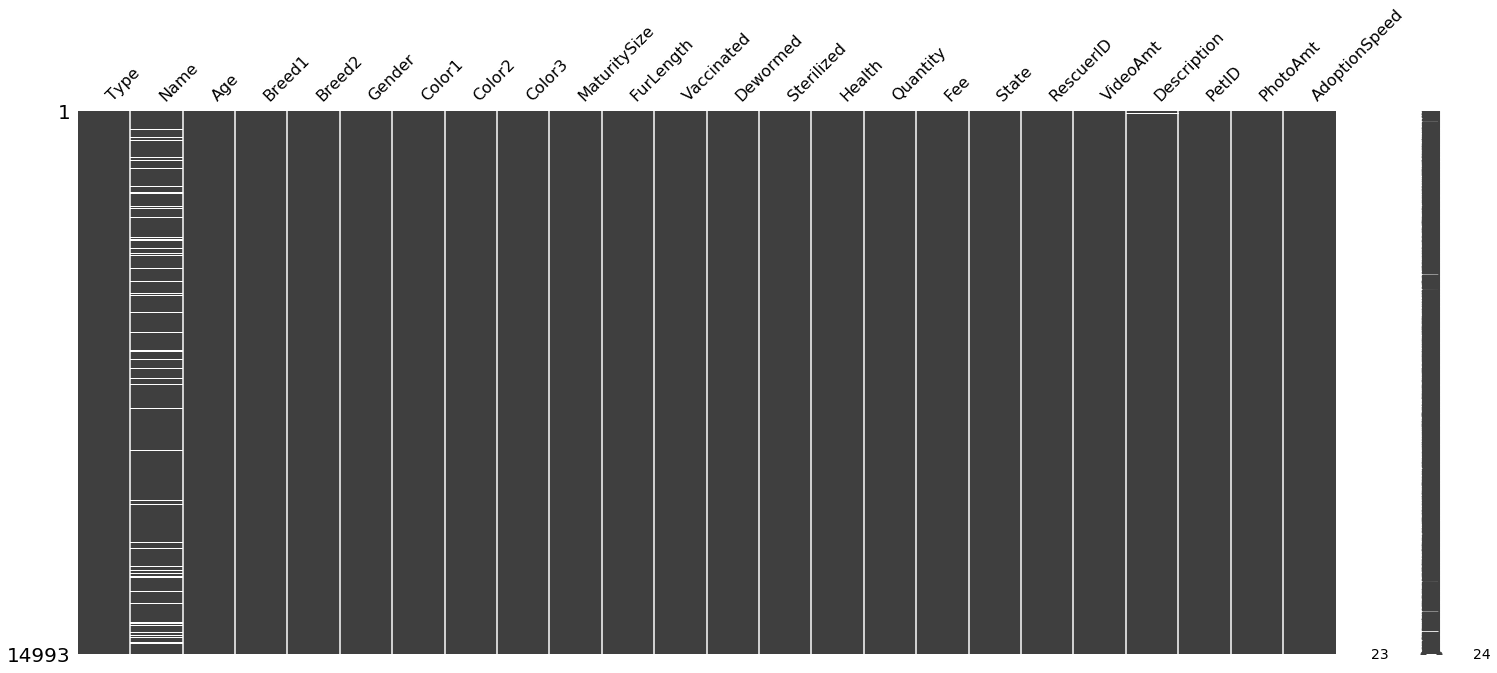

In [5]:
msno.matrix(train)

In [6]:
missing_values = {col: train[col].isnull().sum() for col in train.columns}
missing_values

{'Type': 0,
 'Name': 1257,
 'Age': 0,
 'Breed1': 0,
 'Breed2': 0,
 'Gender': 0,
 'Color1': 0,
 'Color2': 0,
 'Color3': 0,
 'MaturitySize': 0,
 'FurLength': 0,
 'Vaccinated': 0,
 'Dewormed': 0,
 'Sterilized': 0,
 'Health': 0,
 'Quantity': 0,
 'Fee': 0,
 'State': 0,
 'RescuerID': 0,
 'VideoAmt': 0,
 'Description': 12,
 'PetID': 0,
 'PhotoAmt': 0,
 'AdoptionSpeed': 0}

# Label: AdoptionSpeed

How much time would it take for an adoptee to adopt the given animal:

- 0 - Pet was adopted on the same day as it was listed.
- 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
- 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
- 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
- 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days). 

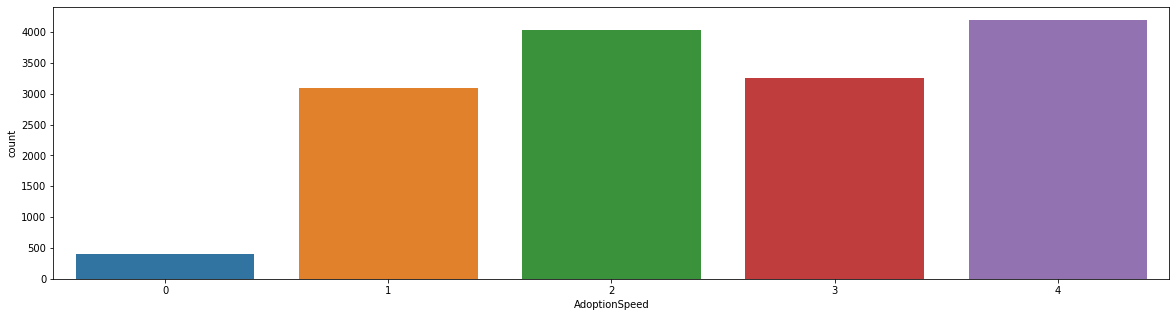

In [7]:
plt.figure(figsize=(20,5))
viz = train[["AdoptionSpeed"]]
sns.countplot(data=viz, x="AdoptionSpeed")

In [8]:
import operator
percentile = train[["AdoptionSpeed"]]
counts = dict(percentile["AdoptionSpeed"].value_counts())
for key in sorted(counts.keys()):
    item = counts[key]
    print("%d:\t%.2f%%" %(key, 100.0 * item / sum(percentile["AdoptionSpeed"])))

0:	1.09%
1:	8.19%
2:	10.70%
3:	8.64%
4:	11.12%


The label is balanced except for the value of 0, so we will need to check the F-1 score when our model is ready.

In [9]:
def plot_categorical_variable(df, category, target="AdoptionSpeed", cat_to_label=None, subplot=False):
    if cat_to_label == None:
        cat_to_label = {c: c for c in df[category].unique()}
    plt.figure(figsize=(20, 10))
    num_categories = len(df[category].unique())
    for i, cat in enumerate(df[category].unique()):
        if subplot:
            plt.subplot((num_categories / 2)+1, (num_categories % 2)+1, i+1)
        sns.distplot(df[df[category] == cat][target], kde_kws={"label": cat_to_label[cat]})

In [10]:
cat_df = pd.DataFrame() # for categorical variables
cat_df["AdoptionSpeed"] = train["AdoptionSpeed"]
cont_df = pd.DataFrame() # for continous variables
cont_df["AdoptionSpeed"] = train["AdoptionSpeed"]

# Feature: Type

What is the animal's type:

- 1: Dog
- 2: Cat

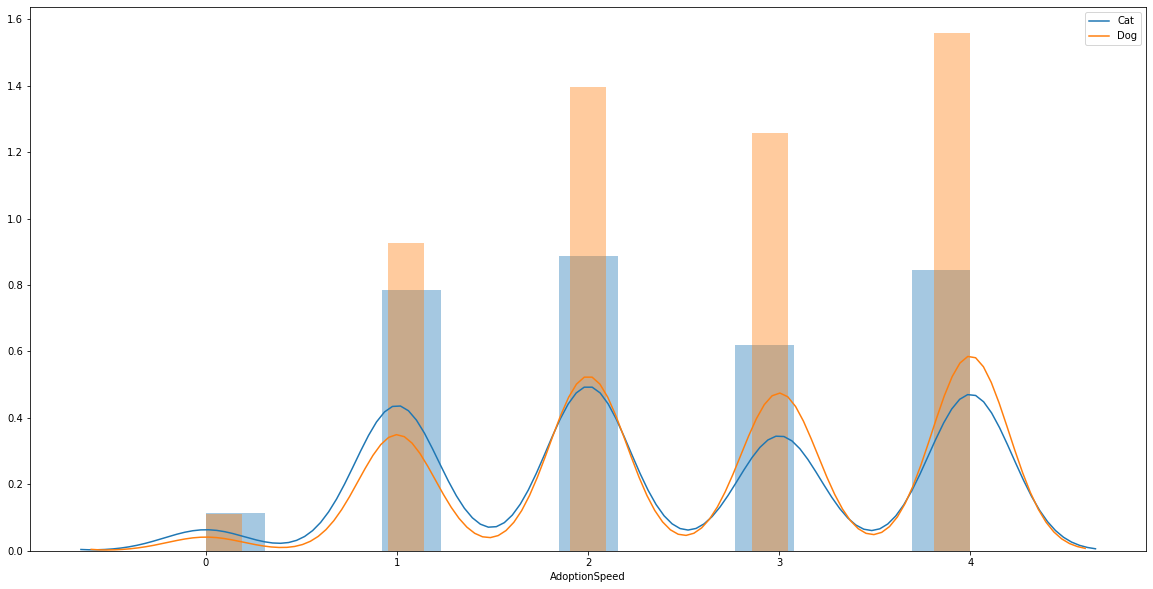

In [11]:
viz = train[["Type", "AdoptionSpeed"]]
plot_categorical_variable(viz, "Type", cat_to_label={1: "Dog", 2: "Cat"})

Cats and dogs categories have the same distribution for the Type 0 adoption, and have similiar distributions for the other sets as well.

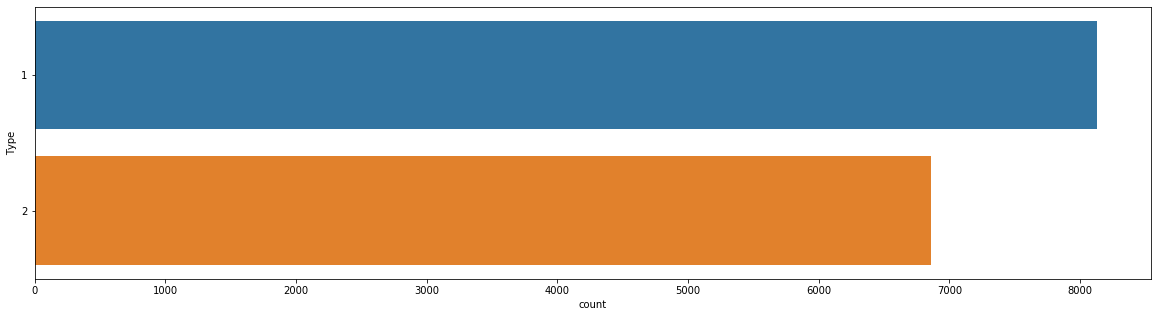

In [12]:
plt.figure(figsize=(20,5))
viz = train[["Type", "AdoptionSpeed"]]
sns.countplot(data=viz, y="Type")

In [13]:
missing_values["Type"]

0

In [14]:
cat_df["Type"] = train["Type"]
cont_df["Type"] = train["Type"]

The type variable is balanced on the train set.

# Feature: Name

The name of the pet

In [15]:
viz = train[["Name", "AdoptionSpeed"]]
viz["Name"].value_counts()

Baby                          66
Lucky                         64
Brownie                       54
No Name                       54
Mimi                          52
Blackie                       49
Puppy                         45
Kittens                       39
Kitty                         39
Max                           39
Oreo                          36
Coco                          35
Tiger                         34
Angel                         33
Milo                          32
Snowy                         30
Bobby                         30
Kiki                          29
Lucy                          29
Lily                          28
Tom                           27
Ginger                        26
Puppies                       26
Prince                        25
Happy                         25
Daisy                         24
Lola                          23
Bella                         23
Rocky                         23
Kitten                        23
          

In [16]:
missing_values["Name"], missing_values["Name"] / len(train)

(1257, 0.08383912492496498)

Almost 10000 names, we either skip this variable or mine it for information. (Also it has to most missing values).

In [17]:
#yanked from ./PetNames.ipynb
# creates names_df
import nltk
nltk.download("all")
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize 

stop_words = set(stopwords.words('english'))

def tagger(record): 
    
    if not record or type(record) != str:
        return np.nan
    tokenized = sent_tokenize(record)
    for i in tokenized: 

        words_list = nltk.word_tokenize(i) 
        words_list = [w for w in words_list if not w in stop_words]  

        tagged = nltk.pos_tag(words_list) 

    return tagged


names_df = train[["Name"]]
names_df["POS"] = names_df["Name"].apply(tagger)


def mark_as_spam(record):
    if type(record) != list:
        return False
    if len(record) == 1 and record[0][1] in ["RB", "JJ", "VB"]: # for simple pet names like: Lily, Rocky
        return True
    for w, t in record:
        if "DT" in t: # DT PDT WDT should only appear in sentences, not names
            return False
        if not (t == "NN" or t == "NNP" or t == "CC" or w == ","): 
            # CC and , are allowed because of the multi pet records (there can be more pets in one record)
            return False
    return True


names_df["Valid"] = names_df["POS"].apply(mark_as_spam)

names_arr = [name.split() for name in names_df["Name"].values if type(name) == str]
names_flattened = [y for x in names_arr for y in x]

def df(word):
    count = 0
    for sub_arr in names_arr:
        if word in sub_arr:
            count += 1
    return count


tf = dict(pd.Series(names_flattened).value_counts())
N = len(names_arr)

names_df["TF"] = names_df["Name"].apply(lambda name: np.mean([tf[word] for word in name.split()]) if type(name) == str else name)
names_df["IDF"] = names_df["Name"].apply(lambda name: np.mean([np.log(N/df(word)) for word in name.split()]) if type(name) == str else name)
names_df["TF-IDF"] = names_df["Name"].apply(lambda name: np.mean([tf[word]*np.log(N/df(word)) for word in name.split()]) if type(name) == str else name)
names_df.head()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

[nltk_data]    |   Unzipping corpora/toolbox.zip.
[nltk_data]    | Downloading package treebank to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/treebank.zip.
[nltk_data]    | Downloading package twitter_samples to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/twitter_samples.zip.
[nltk_data]    | Downloading package udhr to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/udhr.zip.
[nltk_data]    | Downloading package udhr2 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/udhr2.zip.
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/unicode_samples.zip.
[nltk_data]    | Downloading package universal_treebanks_v20 to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    | Downloading package verbnet to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/verbnet.zip.
[nltk_data]    | Downloading package verbnet3 to /root/nltk_data...
[nltk_data

,Name,POS,Valid,TF,IDF,TF-IDF
0,Nibble,"[(Nibble, JJ)]",True,1.000000,9.527775,9.527775
1,No Name Yet,"[(No, DT), (Name, NN), (Yet, RB)]",False,84.333333,5.185902,424.526611
2,Brisco,"[(Brisco, NNP)]",True,1.000000,9.527775,9.527775
3,Miko,"[(Miko, NN)]",True,18.000000,6.637404,119.473266
4,Hunter,"[(Hunter, NN)]",True,7.000000,7.581865,53.073057


In [18]:
names_df["TF-IDF"] = names_df["TF-IDF"].fillna(names_df["TF-IDF"].mean())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
cat_df["NAME:Valid"] = names_df["Valid"].astype(int)
cat_df["NAME:TF-IDF"] = pd.cut(names_df["TF-IDF"], bins=60)
cat_df.head()

,AdoptionSpeed,Type,NAME:Valid,NAME:TF-IDF
0,2,2,1,"(8.384, 28.583]"
1,0,2,0,"(409.687, 428.742]"
2,3,1,1,"(8.384, 28.583]"
3,2,1,1,"(104.804, 123.859]"
4,2,1,1,"(47.638, 66.693]"


In [20]:
cont_df["NAME:Valid"] = names_df["Valid"].astype(int)
cont_df["NAME:TF-IDF"] = names_df["TF-IDF"]
cont_df.head()

,AdoptionSpeed,Type,NAME:Valid,NAME:TF-IDF
0,2,2,1,9.527775
1,0,2,0,424.526611
2,3,1,1,9.527775
3,2,1,1,119.473266
4,2,1,1,53.073057


# Feature: Age

How old the animal is given in months.

In [21]:
missing_values["Age"]

0

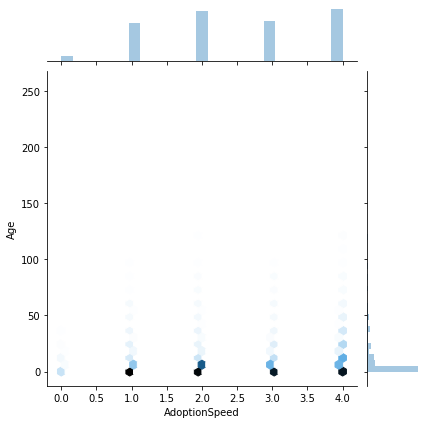

In [22]:
viz = train[["Age", "AdoptionSpeed"]]
sns.jointplot(data=viz, x="AdoptionSpeed", y="Age", kind="hex")

As the plot's right side shows the age feature is not well-balanced and the adoption speeds represent that inbalance.

In [23]:
%pip install pingouin
import pingouin as pg

     |████████████████████████████████| 215kB 925kB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/2a/5c/a7/5a8e31f9ba8945cc4671f4aadc3647f4bf177719227554d829
Successfully built pingouin
Note: you may need to restart the kernel to use updated packages.


In [24]:
ttest_df = train[["Age", "AdoptionSpeed"]]
pg.anova(data=ttest_df, dv="Age", between="AdoptionSpeed", detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,AdoptionSpeed,66247.363,4,16561.841,50.912,1.20803e-42,0.013
1,Within,4875606.454,14988,325.301,-,-,-


### TODO: process ANOVA results

In [25]:
cat_df["Age"] = train["Age"]
cont_df["Age"] = train["Age"]

# Features: Breed1 & Breed2

In [26]:
# Dependencies and utilities for breed feature extraction
%pip install networkx
%pip install node2vec
import networkx as nx
from node2vec import Node2Vec
import ast

def parse_tuple(string):
    try:
        s = ast.literal_eval(str(string))
        if type(s) == tuple:
            return s
        return
    except:
        return
    
def label_to_int(label):
    if label == "NoType":
        return 0
    return breed[breed["BreedName"] == label]["BreedID"].values[0]

Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 24.2MB 1.3MB/s eta 0:00:01     |██████████████████████          | 16.6MB 3.2MB/s eta 0:00:03
     |████████████████████████████████| 71kB 7.0MB/s eta 0:00:011
     |████████████████████████████████| 133kB 1.1MB/s eta 0:00:01
     |████████████████████████████████| 71kB 2.9MB/s eta 0:00:01
     |████████████████████████████████| 5.6MB 2.1MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/b3/58/c5/1fff0e4b9b5f90bb5522967f2d08f026d247b9657e70cbf1db
  Stored in directory: /root/.cache/pip/wheels/5f/ea/fb/5b1a947b369724063b2617011f1540c44eb00e28c3d2ca8692
Successfully built node2vec smart-open
Note: you may need to restart the kernel to use updated packages.


In [27]:
# details in Breeds.ipynb

b1_count = train["Breed1"].value_counts()
b2_count = train["Breed2"].value_counts()

train_breed = train[["Breed1", "Breed2"]]

breed_mod = breed.copy()
breed_mod.loc[-1] = [0, 0, "NoType"]

breed_keys = sorted(list(set(list(b1_count.keys()) + list(b2_count.keys()))))
breed_counts = {breed_mod[breed_mod["BreedID"] == b]["BreedName"].values[0]: 
                [b1_count.get(b, 0), b2_count.get(b, 0)] for b in breed_keys}

edges_df = train_breed.groupby(train_breed.columns.tolist(),as_index=False).size() \
                .reset_index().rename(columns={0:"Count"})
edges_df["NormalizedCount"] = edges_df["Count"] / max(edges_df["Count"])
edges_df = edges_df.drop("Count", axis=1)


G=nx.DiGraph()
dog_nodes = []
cat_nodes = []
for breed_id, animal_type, breed_name in breed_mod.values:
    node = G.add_node(breed_id, type=animal_type, breed_name=breed_name)
    if animal_type == 1:
        dog_nodes.append(node)
    elif animal_type == 2:
        cat_nodes.append(node)
        
# One way edges to the graphs with weight = number of breed1->breed2 connections in the dataset 
for edge in edges_df.values:
    G.add_edge(edge[0], edge[1], weight=edge[2])

G = nx.relabel_nodes(G, {i: G.node[i]['breed_name'] for i in G.nodes()})

G_ = nx.line_graph(G)
mapping = {node: str(node) for node in G_.nodes()}
G_ = nx.relabel_nodes(G_,mapping)

dim = 40

node2vec = Node2Vec(G_, walk_length = 10, dimensions= dim, num_walks = 100, p = 0.25, q = 4, workers = 3)
model = node2vec.fit(iter = 1)

e2v_embeddings = pd.DataFrame(columns = ["Breed1Label", "Breed2Label"] + ["Dim_%d" % i for i in range(dim)])
for i, node_name in enumerate(G_.nodes()):
    breed1, breed2 = parse_tuple(node_name)
    e2v_embeddings.loc[i] = [breed1, breed2] + list(model[node_name])

e2v_embeddings["Breed1Int"] = e2v_embeddings["Breed1Label"].apply(label_to_int)
e2v_embeddings["Breed2Int"] = e2v_embeddings["Breed2Label"].apply(label_to_int)

embedding_df = pd.merge(train[["Breed1", "Breed2"]], e2v_embeddings,  how='left', left_on=['Breed1','Breed2'], right_on = ['Breed1Int','Breed2Int'])
embedding_df = embedding_df[["Dim_%d" % i for i in range(dim)]]

Computing transition probabilities: 100%|██████████| 812/812 [00:01<00:00, 652.11it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [28]:
cont_df = cont_df.join(embedding_df)

In [29]:
def cut(df):
    return pd.cut(df, bins=10)
cat_df = cat_df.join(embedding_df.apply(cut))

# Feature: Gender

- 1 = Male
- 2 = Female
- 3 = Mixed

Mixed can happen if more than one pets are registered on the same record

In [30]:
missing_values["Gender"]

0

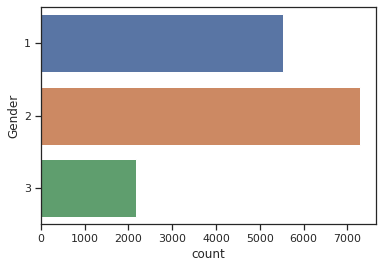

In [31]:
viz = train[["Gender", "AdoptionSpeed"]]
sns.countplot(data=viz, y="Gender")

The feature is well distributed for model creation.

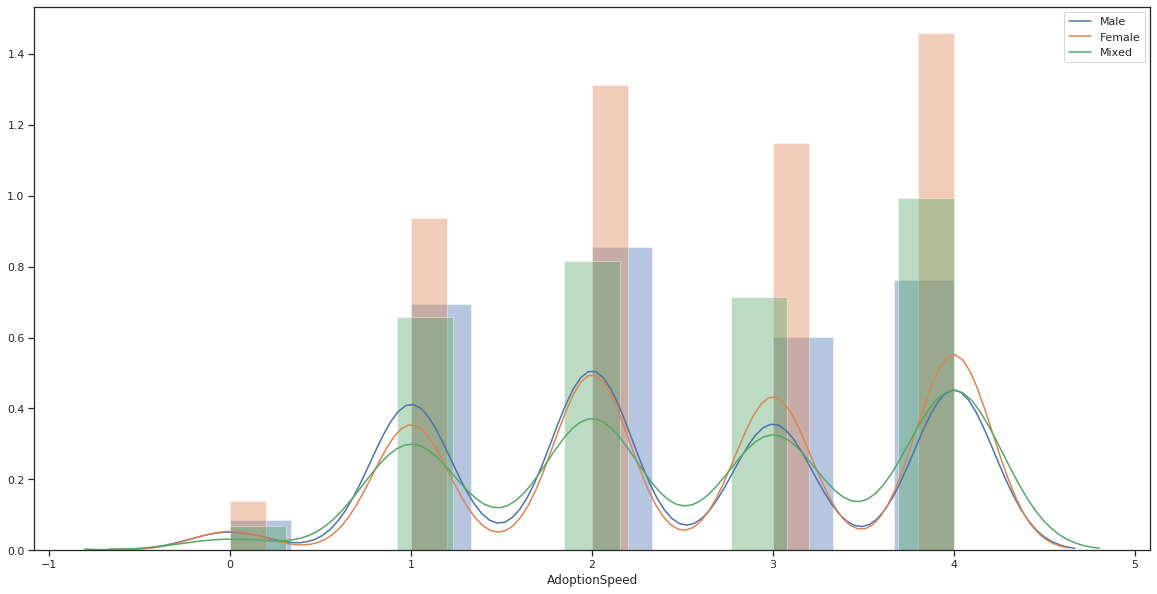

In [32]:
viz = train[["Gender", "AdoptionSpeed"]]
plot_categorical_variable(viz, "Gender", cat_to_label={1: "Male", 2: "Female", 3: "Mixed"})

Altought there are more female animals in the dataset, double the amount of females get adopted on the first day than of males of mixed.

In [33]:
cat_df["Age"] = train["Age"]
cont_df["Age"] = train["Age"]

# Feature: Color1 & Color2 & Color3

Values:

In [34]:
color

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream
5,6,Gray
6,7,White


In [35]:
missing_values["Color1"], missing_values["Color2"], missing_values["Color3"]

(0, 0, 0)

Altough this feature is like breed1 and breed2, where two features were from the same domain with difference in importance, these features have 7 items, and 20000+ edges (Color1->Color2 x 10000 + Color2+Color3 x 10000) even if it is a directed graph it would be a fully connected graph. An edge case is: Black -> Black -> Black be represented, there can only be one recurrence in the graph. We will have to try and find an other encoding.

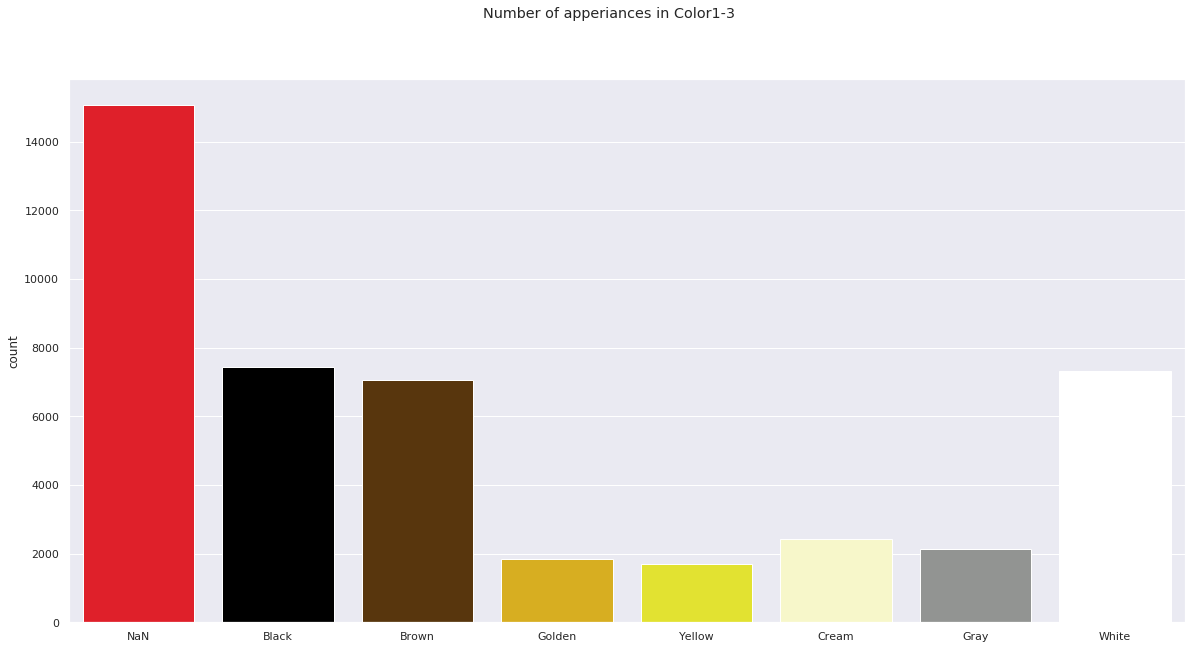

In [36]:
fig = plt.figure(figsize=(20,10))
viz = train[["Color%d" %i for i in range(1,4)]]

fig.suptitle("Number of apperiances in Color1-3")

with sns.axes_style("darkgrid"):
    g = sns.countplot(list(viz["Color1"]) +  list(viz["Color2"]) + list(viz["Color3"]), 
                  palette=sns.xkcd_palette(
                      ["bright red"] + [value.lower() if value != "Gray" else "grey" for value in color["ColorName"].values]
                  ))

    g.set_xticklabels(["NaN"] + color["ColorName"].values.tolist())
    

sns.set_palette("muted")

<Figure size 1440x1440 with 0 Axes>

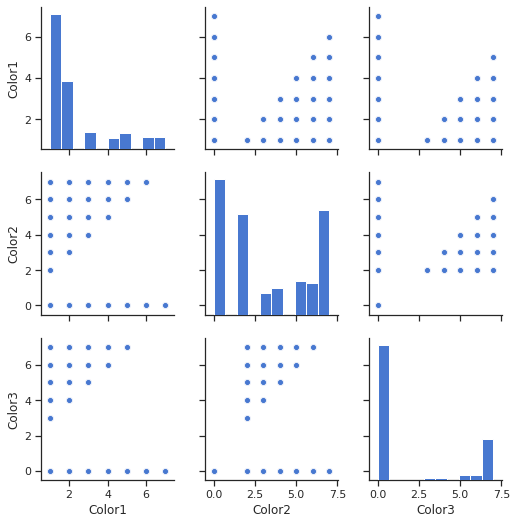

In [37]:
plt.figure(figsize=(20,20))
viz = train[["Color%d" %i for i in range(1,4)]]

sns.pairplot(viz,)

In [38]:
frame = train[["Color%d" %i for i in range(1,4)]]
for i in range(1, 4):
    arr = np.array(list(frame["Color%d" % i]))
    print("Color%d: %.2f%% of color data is NaN" % (i, np.sum(arr == 0)/len(arr) * 100))

Color1: 0.00% of color data is NaN
Color2: 29.82% of color data is NaN
Color3: 70.73% of color data is NaN


Color2 and Color3 are not even worth using because of the missing values / empty values. 

Instead we can create a ColorNumber column, that counts how many color the given animal has.

For example: 

| Color1 | Color2 | Color3 | ColorNumber |
| ------ | ------ | ------ | ----------- |
| 1      | 4      | 2      | **3**       |
| 1      | 3      | 0      | **2**       |
| 1      | 0      | 0      | **1**       |

In [39]:
frame = train[["Color%d" % i for i in range(1,4)]]
frame["Color1"].value_counts(normalize=True)

1    0.495365
2    0.250117
3    0.063163
5    0.058961
6    0.045621
7    0.044487
4    0.042286
Name: Color1, dtype: float64

Altough Color1 has no missing values, the distribution is very uneven. Anything that is below 10% will be grouped as the same label, so we get a distribution of 50%, 25%, 25%.

In [40]:
train_with_colnum = train.copy()
train_with_colnum["ColorNumber"] = train_with_colnum.apply(lambda rec: int(rec["Color2"] != 0) + int(rec["Color3"] != 0) + 1, axis=1)

cat_df["ColorNumber"] = train_with_colnum["ColorNumber"]
cont_df["ColorNumber"] = train_with_colnum["ColorNumber"]

train_with_colnum.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,ColorNumber
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,2
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,2
3,1,Miko,4,307,0,2,1,2,0,2,...,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,1


In [41]:
frame = train[["Color%d" % i for i in range(1,4)]]
values_not_to_group = list(dict(frame["Color1"].value_counts(normalize=True)).keys())[:2] # top 2 values

train_reduced_color = train.copy()
train_reduced_color["ColorReduced"] = train_reduced_color.apply(
    lambda rec: 0 if rec["Color1"] not in values_not_to_group else rec["Color1"], axis=1)
# 0 = Golden/Yellow/Cream/Gray/White
# 1 = Black
# 2 = Brown

cat_df["ColorReduced"] = train_reduced_color["ColorReduced"]
cont_df["ColorReduced"] = train_reduced_color["ColorReduced"]

train_reduced_color.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,ColorReduced
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,1
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,1
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,2
3,1,Miko,4,307,0,2,1,2,0,2,...,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,1
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,1


# Feature: MaturitySize

Size of mature pet.

- 1 = Small
- 2 = Medium
- 3 = Large
- 4 = Extra Large
- 0 = Not Specified

In [42]:
missing_values["MaturitySize"]

0

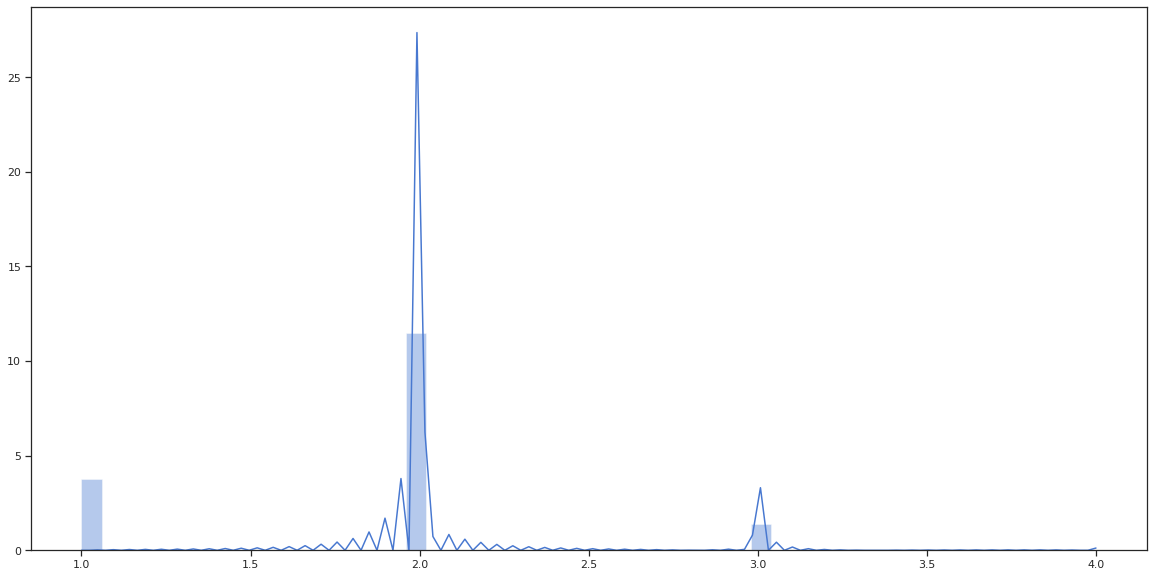

In [43]:
plt.figure(figsize=(20,10))
viz = train[["MaturitySize"]]
sns.distplot(viz)

All of the pets have been labeled with maturity size, so there is no 0 values.

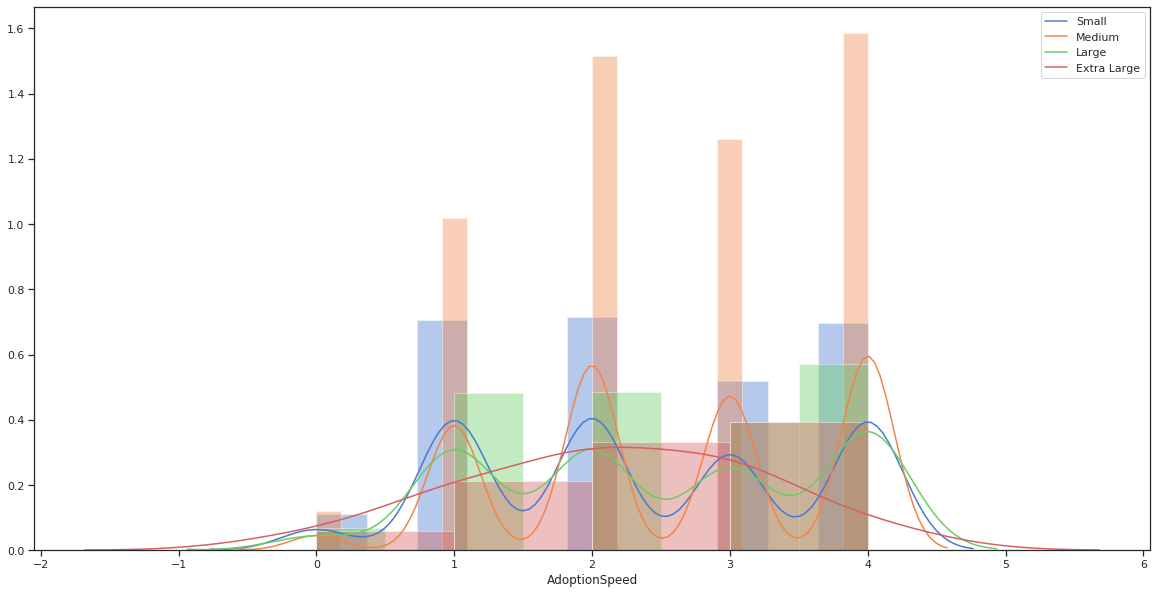

In [44]:
viz = train[["MaturitySize", "AdoptionSpeed"]]

plot_categorical_variable(viz, "MaturitySize", cat_to_label={1: "Small", 2: "Medium", 3: "Large", 4: "Extra Large"})

Although medium size is overrepresented, all sizes are well distributed.

In [45]:
cat_df["MaturitySize"] = train["MaturitySize"]
cont_df["MaturitySize"] = train["MaturitySize"]

# Feature: FurLength

The length of the fur of the pet.

- 1 = Short
- 2 = Medium
- 3 = Long
- 0 = Not Specified

In [46]:
missing_values["FurLength"]

0

1    0.587474
2    0.357567
3    0.054959
Name: FurLength, dtype: float64

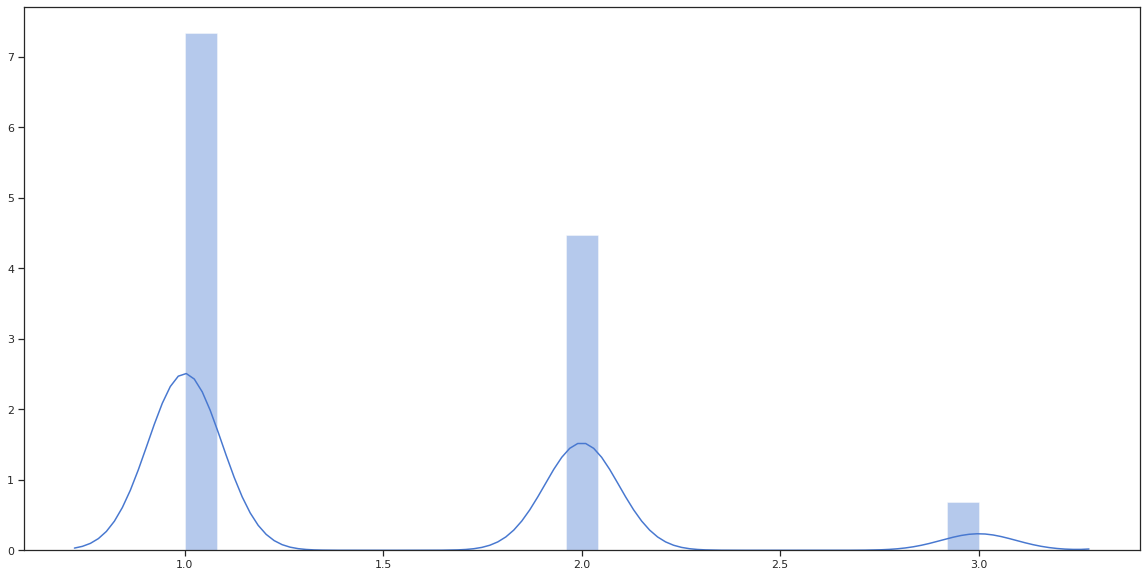

In [47]:
plt.figure(figsize=(20,10))
viz = train[["FurLength"]]
sns.distplot(viz)
viz["FurLength"].value_counts(normalize=True)

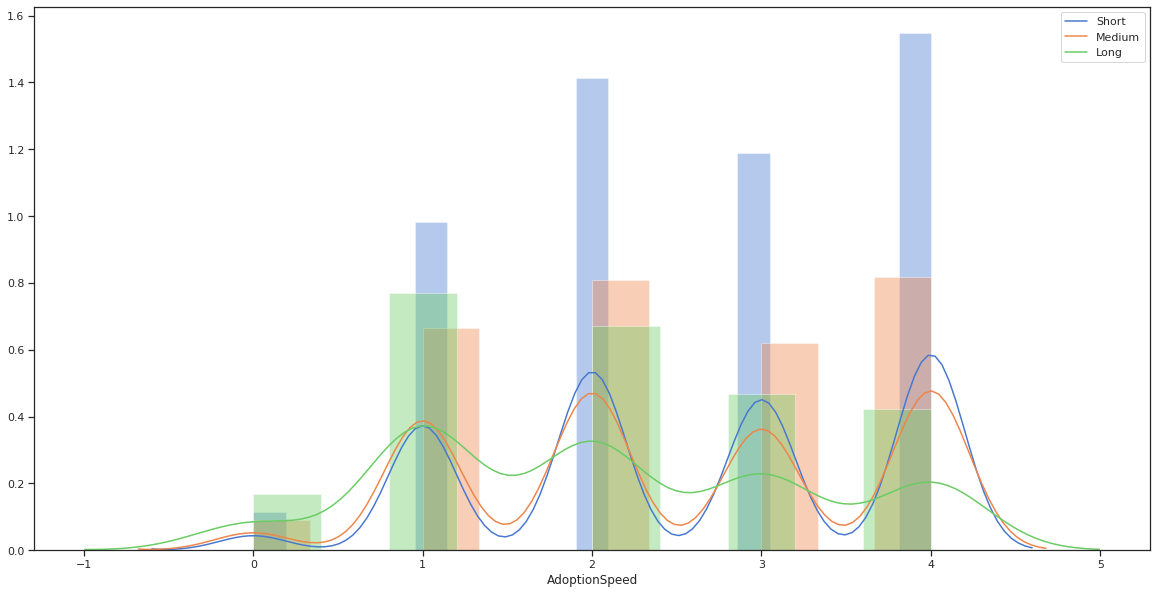

In [48]:
viz = train[["FurLength", "AdoptionSpeed"]]

plot_categorical_variable(viz, "FurLength", cat_to_label={1: "Short", 2: "Medium", 3: "Long"})

There are much fewer long fur pets than short or medium, but the distribution shows they are adopted faster than the other 2 types. Maybe people like fluffy animals or the long fur animals are underrepresented in the dataset.

In [49]:
cat_df["FurLength"] = train["FurLength"]
cont_df["FurLength"] = train["FurLength"]

# Feature: Vaccinated

Wether or not the pet has been vaccinated

- 1 = Yes
- 2 = No
- 3 = Not Sure

In [50]:
missing_values["Vaccinated"]

0

2    0.482025
1    0.393384
3    0.124591
Name: Vaccinated, dtype: float64

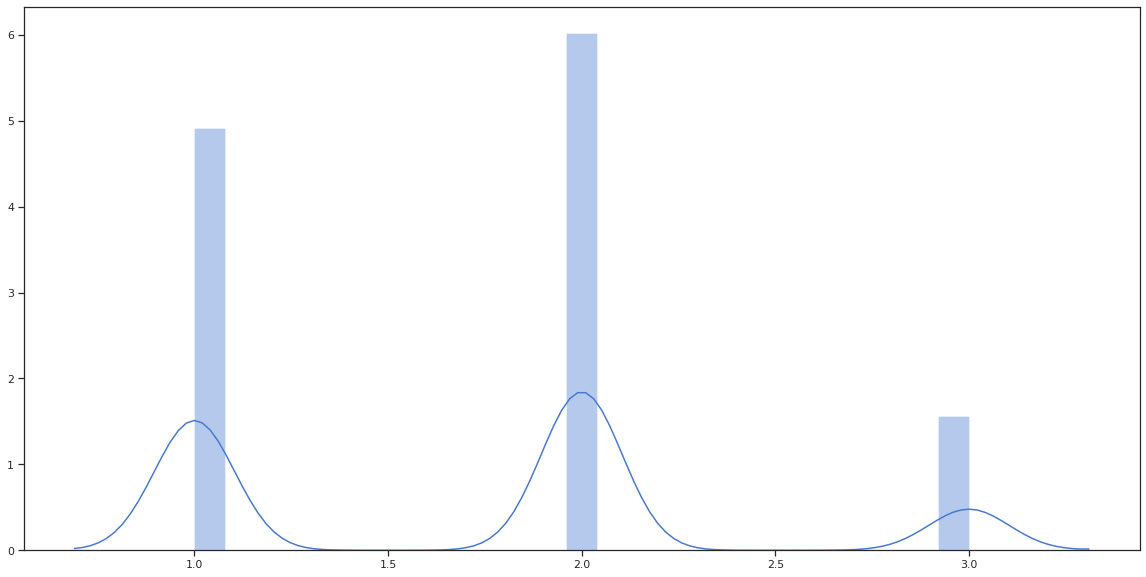

In [51]:
plt.figure(figsize=(20,10))
viz = train[["Vaccinated"]]
sns.distplot(viz)
viz["Vaccinated"].value_counts(normalize=True)

12% of the data is NaN, should it be deleted, or randomly sampled?

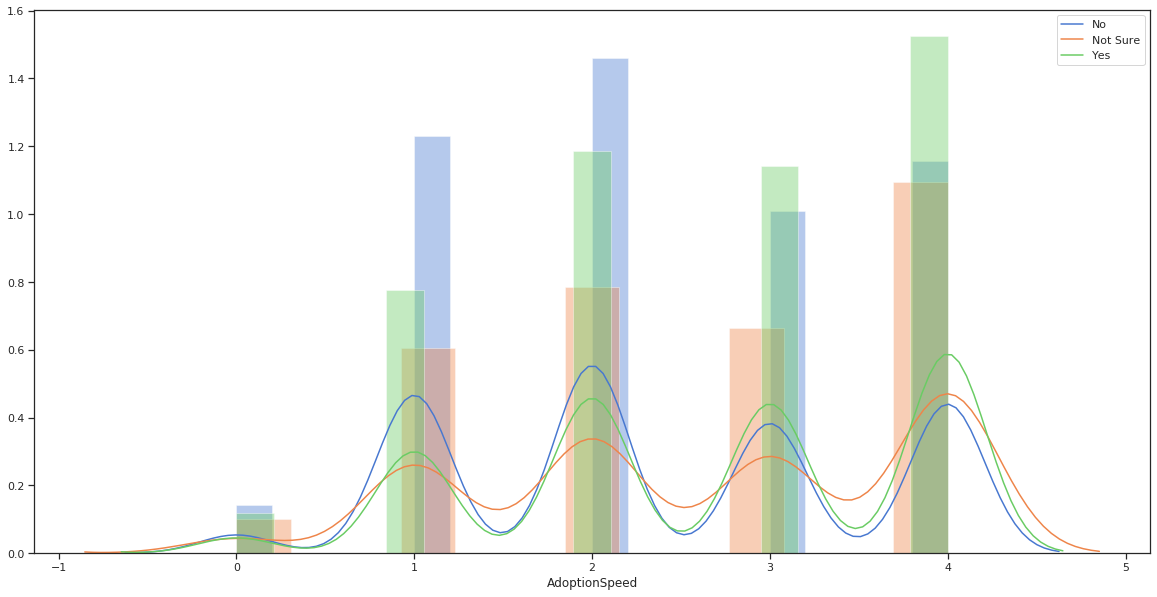

In [52]:
viz = train[["Vaccinated", "AdoptionSpeed"]]

plot_categorical_variable(viz, "Vaccinated", cat_to_label={1: "Yes", 2: "No", 3: "Not Sure"})

If a pet is not vaccinated it is more likely to be adopted early. Why?

In [53]:
cat_df["Vaccinated"] = train["Vaccinated"]
cont_df["Vaccinated"] = train["Vaccinated"]

# Feature: Dewormed

Wether or not the pet is dewormed

- 1 = Yes
- 2 = No
- 3 = Not Sure

In [54]:
missing_values["Dewormed"]

0

1    0.560061
2    0.321150
3    0.118789
Name: Dewormed, dtype: float64

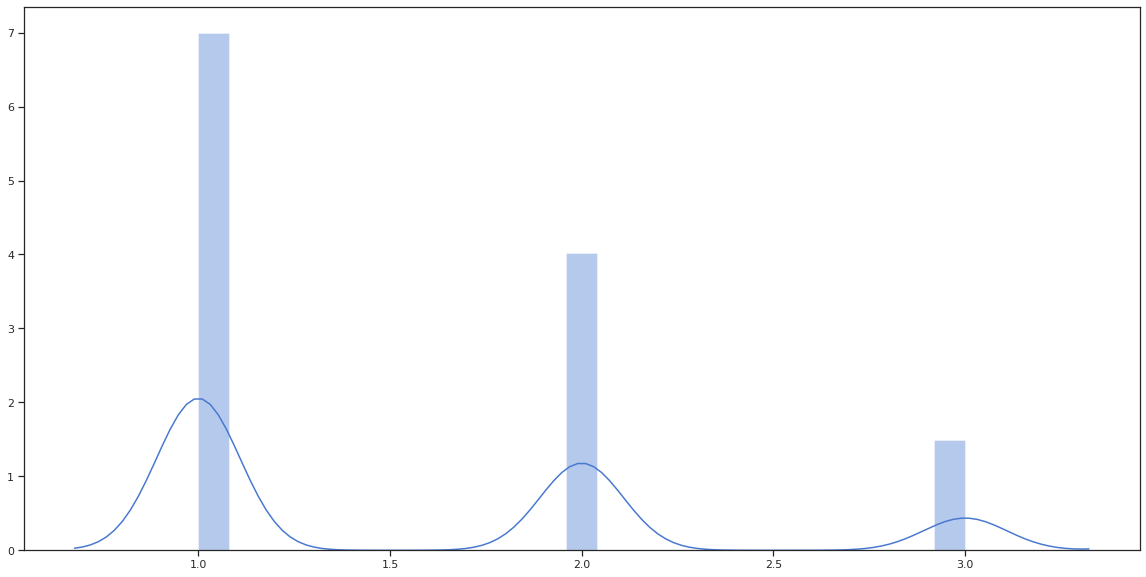

In [55]:
plt.figure(figsize=(20,10))
viz = train[["Dewormed"]]
sns.distplot(viz)
viz["Dewormed"].value_counts(normalize=True)

Here 11% of data is unknown. Resample or delete again?

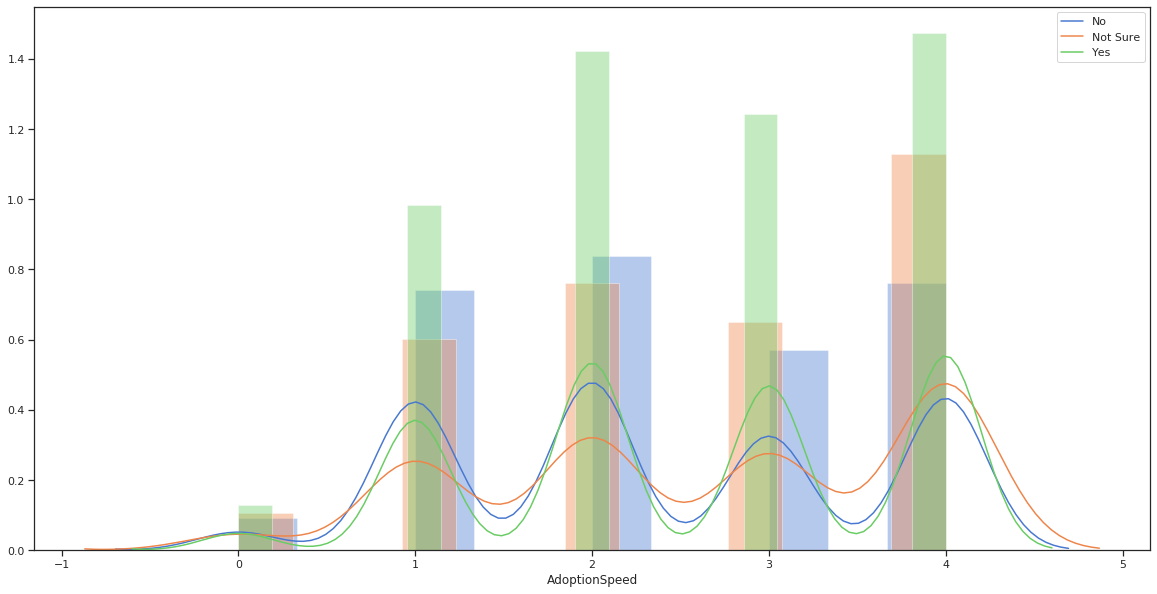

In [56]:
viz = train[["Dewormed", "AdoptionSpeed"]]

plot_categorical_variable(viz, "Dewormed", cat_to_label={1: "Yes", 2: "No", 3: "Not Sure"})

All three categories show the same tendencies in adoption rates.

In [57]:
cat_df["Dewormed"] = train["Dewormed"]
cont_df["Dewormed"] = train["Dewormed"]

# Feature: Sterilized

Wether or not the pet is sterilized

- 1 = Yes
- 2 = No
- 3 = Not Sure

In [58]:
missing_values["Sterilized"]

0

2    0.672114
1    0.206830
3    0.121056
Name: Sterilized, dtype: float64

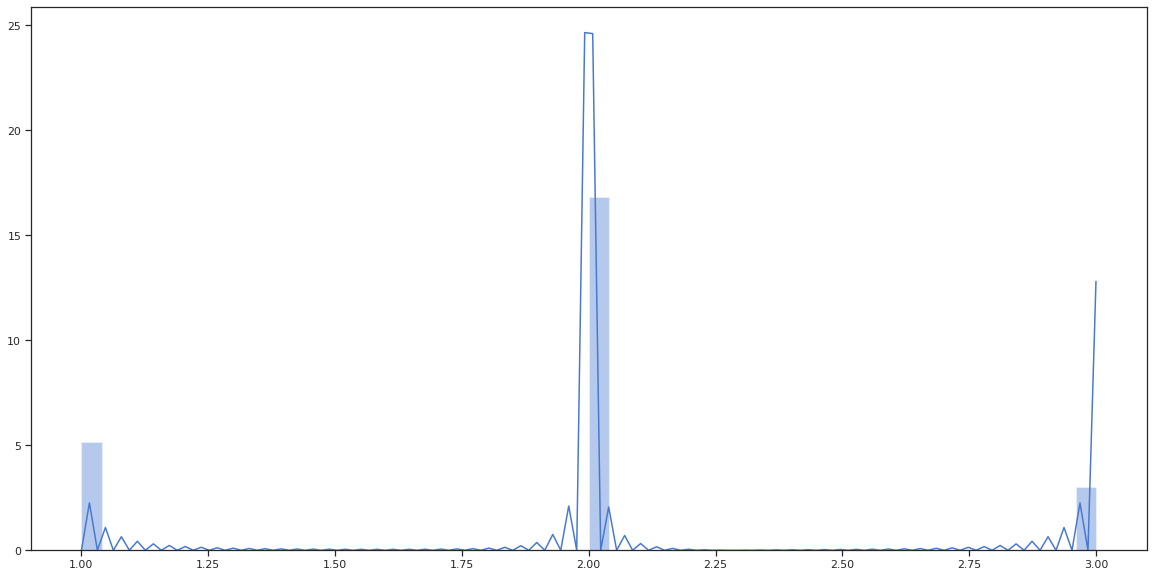

In [59]:
plt.figure(figsize=(20,10))
viz = train[["Sterilized"]]
sns.distplot(viz)
viz["Sterilized"].value_counts(normalize=True)

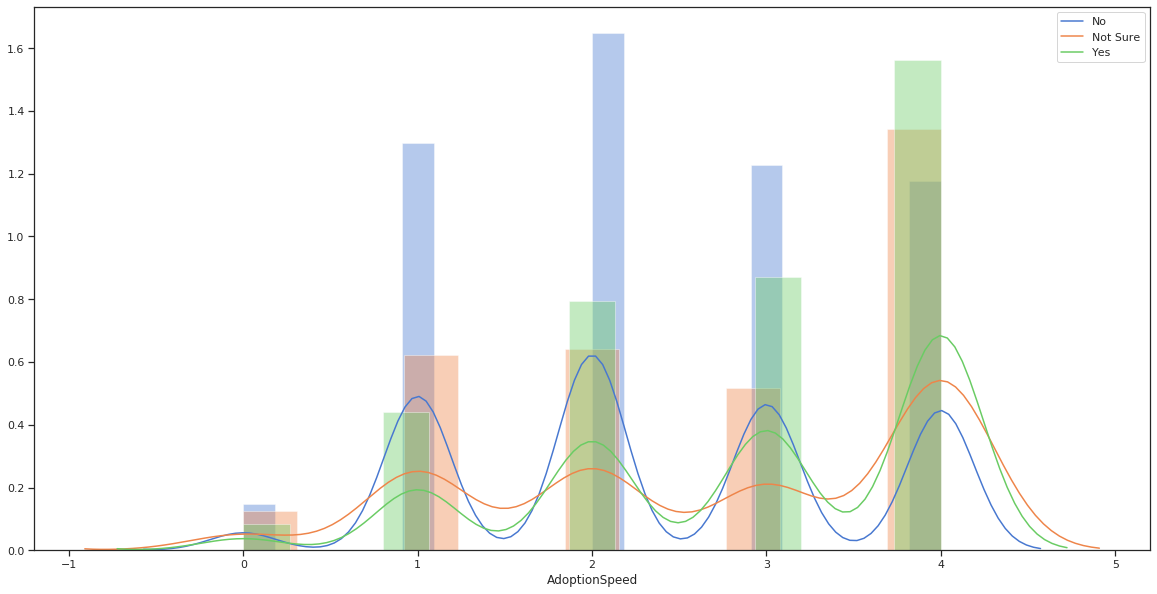

In [60]:
viz = train[["Sterilized", "AdoptionSpeed"]]

plot_categorical_variable(viz, "Sterilized", cat_to_label={1: "Yes", 2: "No", 3: "Not Sure"})

Non sterilized pets are more likely to be adopted early (or at least less likely to be adopted late).

In [61]:
cat_df["Sterilized"] = train["Sterilized"]
cont_df["Sterilized"] = train["Sterilized"]

# Feature: Health

The pet's health condition.

- 1 = Healthy
- 2 = Minor Injury
- 3 = Serious Injury
- 0 = Not Specified

In [62]:
missing_values["Health"]

0

1    0.965651
2    0.032082
3    0.002268
Name: Health, dtype: float64

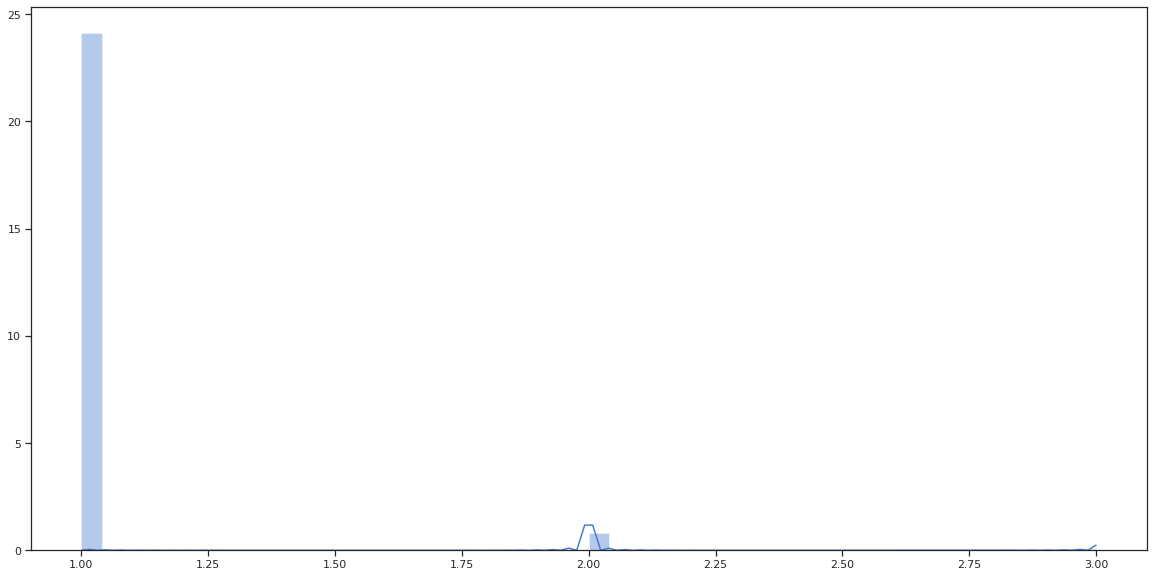

In [63]:
plt.figure(figsize=(20,10))
viz = train[["Health"]]
sns.distplot(viz)
viz["Health"].value_counts(normalize=True)

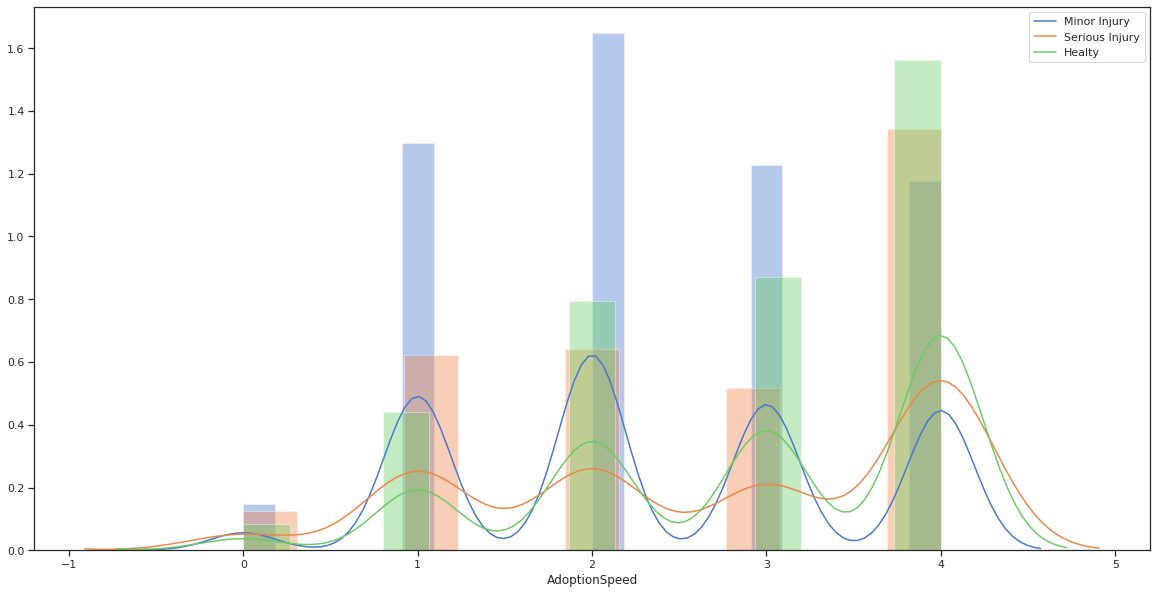

In [64]:
viz = train[["Sterilized", "AdoptionSpeed"]]

plot_categorical_variable(viz, "Sterilized", cat_to_label={1: "Healty", 2: "Minor Injury", 3: "Serious Injury"})

It might not even be useful to use the Health feature because it is dominated by healthy animals.

In [65]:
viz = train[["Health"]]
viz["Health"].value_counts()

1    14478
2      481
3       34
Name: Health, dtype: int64

Either we drop the column as is, or drop the non-healthy animals and build a separate classifier for them.

# Feature: Quantity

The quantity of the animals represented in the record.

1     0.771360
2     0.094844
3     0.048423
4     0.035417
5     0.022210
6     0.012339
7     0.005603
8     0.003468
9     0.002201
10    0.001267
20    0.000800
11    0.000667
12    0.000400
15    0.000267
17    0.000200
16    0.000200
13    0.000133
14    0.000133
18    0.000067
Name: Quantity, dtype: float64

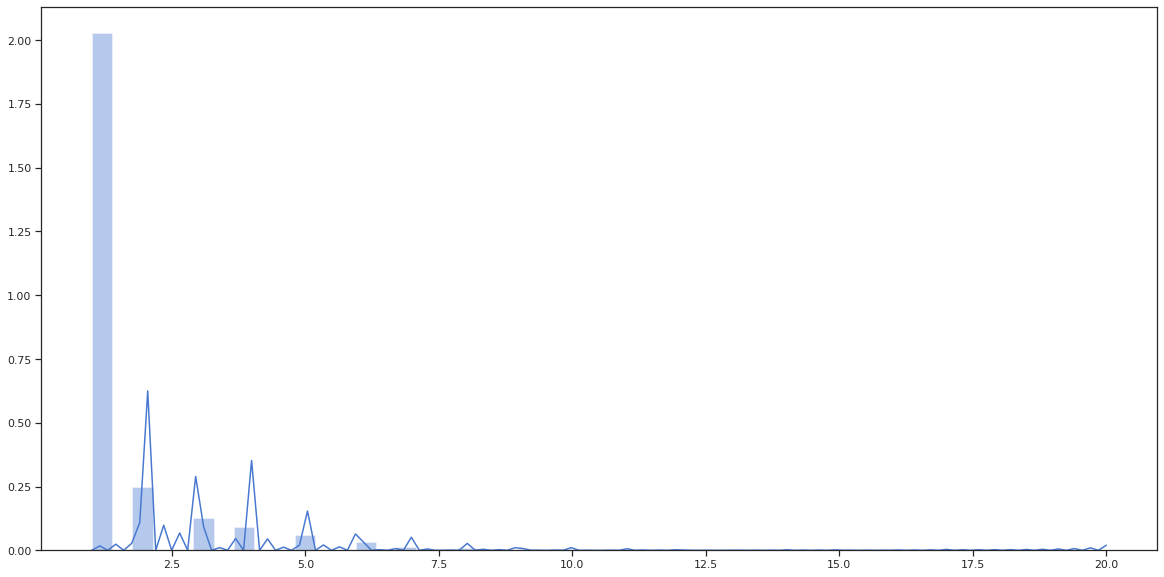

In [66]:
plt.figure(figsize=(20,10))
viz = train[["Quantity"]]
sns.distplot(viz)
viz["Quantity"].value_counts(normalize=True)

In [67]:
len(train) - viz["Quantity"].value_counts()[1]

3428

There are 3.4k non single pets in the dataset. We binarize this varable in such way that Quantity == 1 pets are separated from the rest to see if it effects the AdoptionSpeed.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


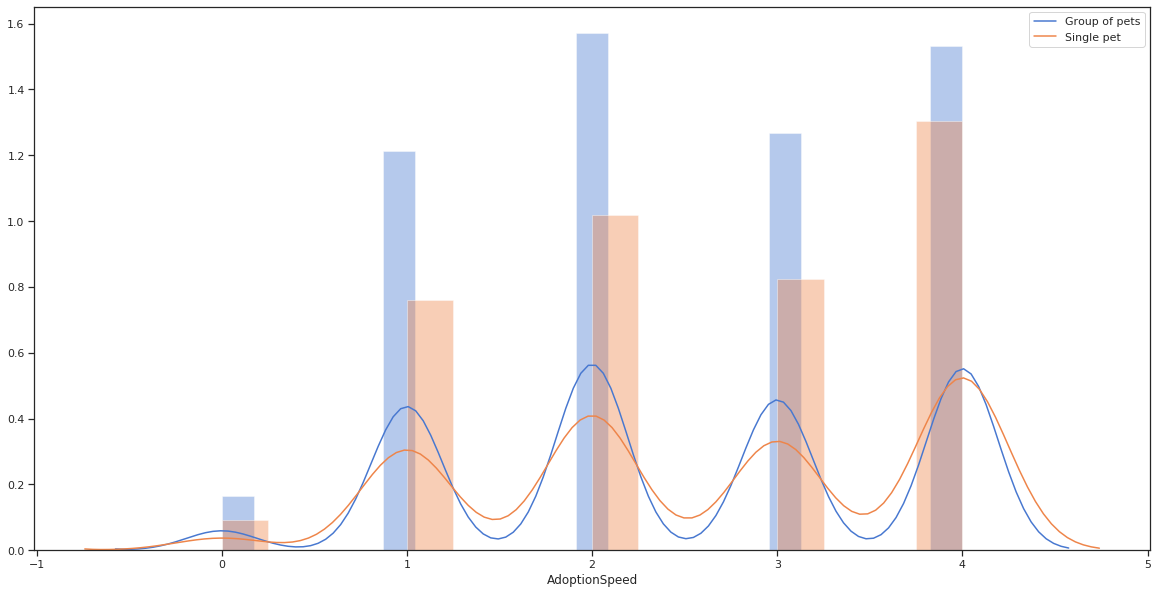

In [68]:
viz = train[["Quantity", "AdoptionSpeed"]]
viz["IsBulk"] = viz.apply(lambda rec: rec["Quantity"] != 1, axis=1)
plot_categorical_variable(viz, "IsBulk", cat_to_label={True: "Single pet", False: "Group of pets"})

Bulk records show the same tendency as single pet records, but groups of pets are more likely to be adopted early.

In [69]:
frame = train[["Quantity", "AdoptionSpeed"]]
frame["IsBulk"] = frame.apply(lambda rec: rec["Quantity"] != 1, axis=1)

cat_df["IsBulk"] = frame["IsBulk"]
cont_df["Quantity"] = frame["Quantity"]
cont_df["IsBulk"] = frame["IsBulk"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Feature: Fee

The fee the new owner needs to pay for the pet.

0.8445941439338358

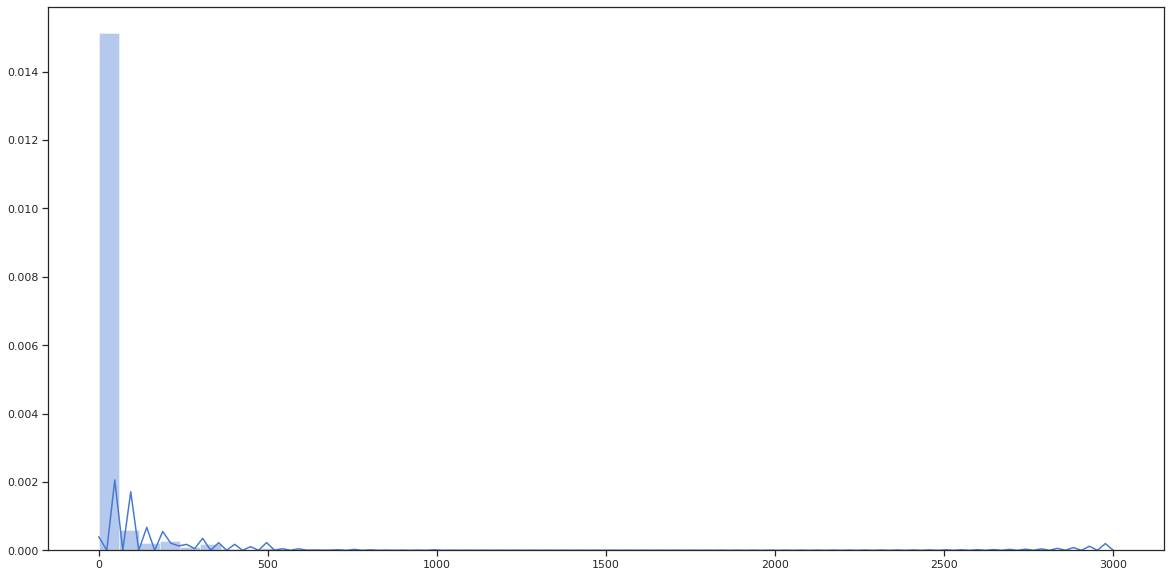

In [70]:
plt.figure(figsize=(20,10))
viz = train[["Fee"]]
sns.distplot(viz)
viz["Fee"].value_counts(normalize=True)[0] # plot the free one only

We can use the same reasoning here as in the quantity section. with creating the isFree feature. But first let's take a look at the distribution of the fees over the adoption speed.

<Figure size 1440x720 with 0 Axes>

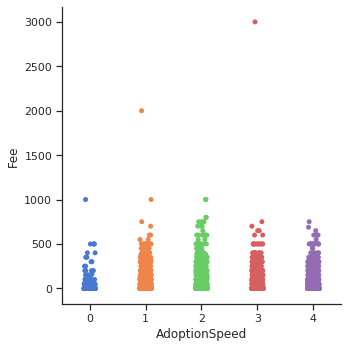

In [71]:
plt.figure(figsize=(20,10))
viz = train[["Fee", "AdoptionSpeed"]]
sns.catplot(data=viz, y="Fee", x="AdoptionSpeed")

The 1500+ fee outliers could be deleted so it does not confuse the model, or we could just use the isFree column instead of the fee column.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


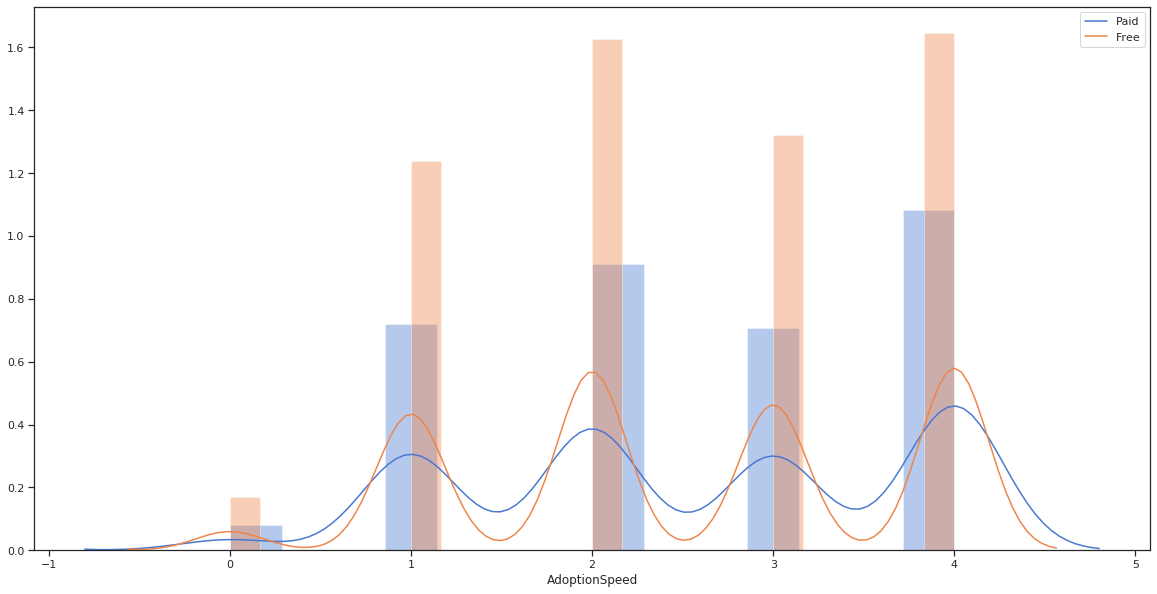

In [72]:
viz = train[["Fee", "AdoptionSpeed"]]
viz["IsFree"] = viz.apply(lambda rec: rec["Fee"] == 0, axis=1)

plot_categorical_variable(viz, "IsFree", cat_to_label={True: "Free", False: "Paid"})

Free pets find their home earlier than paid according to the curve at AdoptionSpeed = 0.

In [73]:
frame = train[["Fee", "AdoptionSpeed"]]
frame["IsFree"] = frame.apply(lambda rec: rec["Fee"] == 0, axis=1)

cat_df["IsFree"] = frame["IsFree"]
cont_df["IsFree"] = frame["IsFree"]
# We do not add fee to cont df for now, maybe later with removed outliers

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Feature: State

Which state the pet is in.

In [74]:
plt.figure(figsize=(20,10))
viz = train[["State"]].merge(state, left_on="State", right_on="StateID", how="left")
viz["StateName"].value_counts(normalize=True)
#TODO: install basemap somehow and plot to a map
#TODO: add state to cat_df and cont_df
geo_dist_df = pd.DataFrame([[k,v] for k, v in dict(viz["StateName"].value_counts(normalize=True)).items()], columns=["State", "Percentage"])
geo_dist_df

,State,Percentage
0,Selangor,0.581205
1,Kuala Lumpur,0.256453
2,Pulau Pinang,0.056226
3,Johor,0.033816
4,Perak,0.028013
5,Negeri Sembilan,0.016875
6,Melaka,0.009138
7,Kedah,0.007337
8,Pahang,0.005669
9,Terengganu,0.001734


<Figure size 1440x720 with 0 Axes>

In [77]:
%pip install geopandas
%pip install descartes
import geopandas as gpd

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


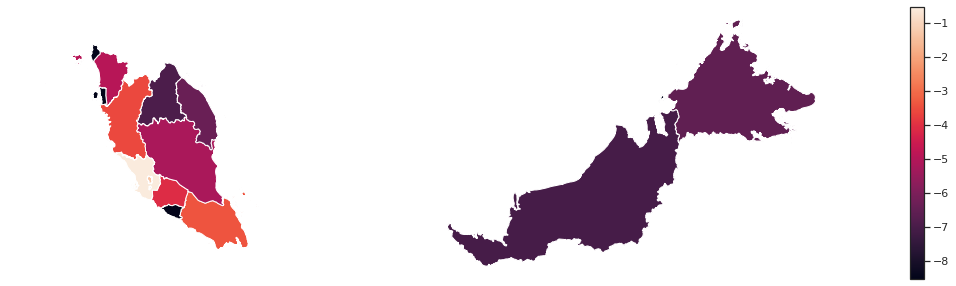

In [78]:
map_df = gpd.read_file("malaysia_shape/Malaysiapoly17.shp")
fig, ax = plt.subplots(1, 1, figsize=(20,5))

map_df = map_df.merge(geo_dist_df, left_on="name", right_on="State", how="left").fillna(-1)

map_df["LogPercentage"] = map_df["Percentage"].apply(np.log)

ax.axis('off')

map_df.plot(column="LogPercentage", ax=ax, legend=True, )

## (**NOTE:** the above map is from -1 to 1, -1 meaning there is no information about the states. Also the scale is logaritmic.)

- There are 3 smaller states that are excluded from the dataset
- One state is dominant in the dataset, and probably it is not because it is the true distribution

Because of the later note, it is advised not to use the state in the model, altough the competiton's goal is to develop tools that help animals find home, this should be adressed later.

# Feature: RescuerID

In [79]:
plt.figure(figsize=(200,100))
viz = train[["RescuerID"]]
viz["RescuerID"].value_counts()

fa90fa5b1ee11c86938398b60abc32cb    459
aa66486163b6cbc25ea62a34b11c9b91    315
c00756f2bdd8fa88fc9f07a8309f7d5d    231
b53c34474d9e24574bcec6a3d3306a0d    228
ee2747ce26468ec44c7194e7d1d9dad9    156
95481e953f8aed9ec3d16fc4509537e8    134
b770bac0ca797cf1433c48a35d30c4cb    111
a042471e0f43f2cf707104a1a138a7df     95
fd970cc91d06d82eebf046340137b272     93
7ed6d84e2e6879245e55447aee39c328     85
e62135526c27156b8479420aad166317     77
438a9bdce8ef4d5948fc40e422d34d0d     75
8b6c5cd067ada5f54ca5ffc7f7b5d896     74
cccb18b8f8b81862f9a1ebc65d651d22     65
001e42763024f9d4abe31e79472b1827     61
530f57b53cb3199e1d5e67733ddc0876     60
3b074cadd2350de62dca7056b9bab6f4     59
3223e1c4cb2bef48823ee5c604b9aa04     52
db784cbcf321e1d8856b312638b94113     52
9238e4f44c71a75282e62f7136c6b240     50
7b107e61f7d24a581e46e0abc4d2a7a7     48
78ec79634d350f6850fdd4a335cab431     47
f45d8c72a87f27427cd28fc3cd2d7ce3     46
2e53c8cd2454a77eb195a039ee28b8f6     44
88a21c30883ab70a93e09035e0a9a754     44


<Figure size 14400x7200 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


<Figure size 14400x7200 with 0 Axes>

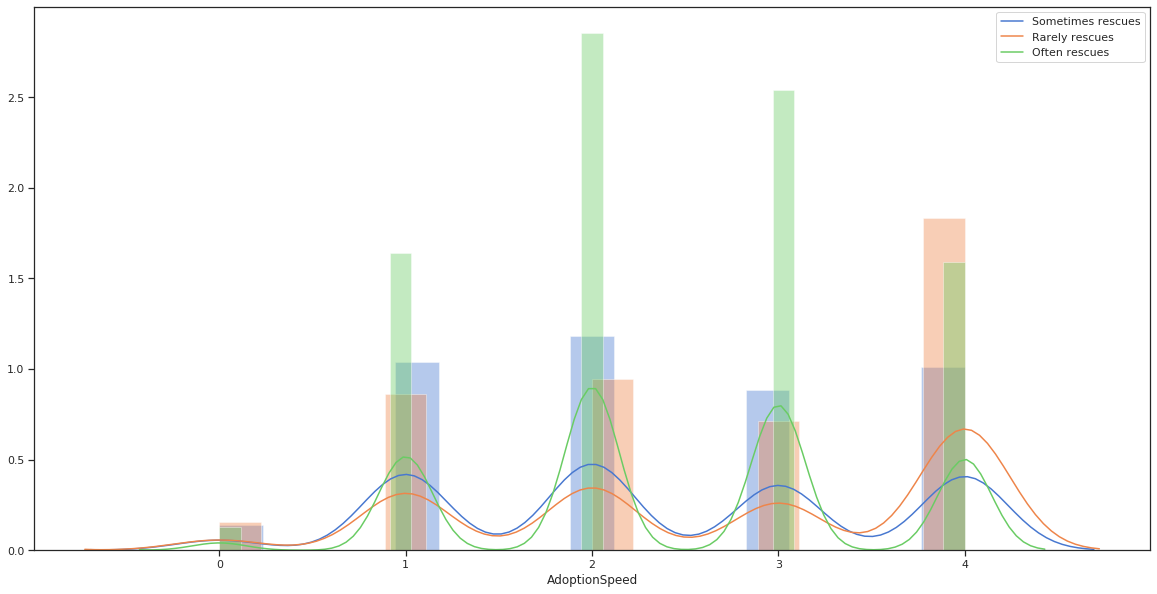

In [107]:
plt.figure(figsize=(200,100))
viz = train[["RescuerID", "AdoptionSpeed"]]
viz["RescuerID"].value_counts()
viz["RescuedAnimalCount"] = viz.groupby("RescuerID").transform(lambda group: len(group))
viz["RACBin"] = pd.qcut(viz["RescuedAnimalCount"], q=3, labels=["Rarely rescues", "Sometimes rescues", "Often rescues"])
plot_categorical_variable(viz, "RACBin")

All three rescuer types seem to be unrelated to the model, but it is to be reviewed later on the training section.

# Feature: VideoAmt

# Feature: Description

# Feature: PetID

# Feature: PhotoAmt

# Other tweeks

### These should be implemented optionally, and should be a parameter for grid-searching

- Replace some of the categorical values with 0 (unspecified)
- Separate Non-Healthy animals from the rest and build a classifier for them
- Remove fee outliers and add fee to cont_df
- Create a model that pairs the pets with the highest likelihood of adoption
- Add RACBin to the model